In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Data Wrangling
The Dataset contain several json columns. We could use json.loads to treat them like dictionary so we can acces the value easily 

In [2]:
json_cols = ['collection','genres','production_companies','production_countries']
mv = pd.read_csv('movies_metadata.csv', parse_dates = ['release_date'])
mv.info()

c:\program files\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3051: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45447 entries, 0 to 45446
Data columns (total 26 columns):
adult                   45447 non-null bool
collection              45447 non-null object
genres                  45447 non-null object
homepage                7775 non-null object
id                      45447 non-null int64
imdb_id                 45430 non-null float64
original_language       45436 non-null object
original_title          45447 non-null object
overview                44495 non-null object
popularity              45444 non-null float64
poster_path             45061 non-null object
production_companies    45447 non-null object
production_countries    45447 non-null object
release_date            45360 non-null datetime64[ns]
budget                  45447 non-null int64
revenue                 45444 non-null float64
runtime                 45188 non-null float64
spoken_languages        45444 non-null object
status                  45363 non-null object
tagline   

In [3]:
for cols in json_cols:
    mv[cols] = mv[cols].apply(json.loads)

In [4]:
cr = pd.read_csv('credits.csv')

cr['cast'] = cr['cast'].apply(json.loads)

'''
cr_cols = ['cast','crew']
for col in cr_cols:
    cr[col] = cr[col].apply(json.loads)
'''
cr.head()

,cast,crew,id,Director
0,"[{'cast_id': 14, 'character': 'Woody (voice)',...","[{""credit_id"": ""52fe4284c3a36847f8024f49"", ""de...",862.0,John Lasseter
1,"[{'cast_id': 1, 'character': 'Alan Parrish', '...","[{""credit_id"": ""52fe44bfc3a36847f80a7cd1"", ""de...",8844.0,Joe Johnston
2,"[{'cast_id': 2, 'character': 'Max Goldman', 'c...","[{""credit_id"": ""52fe466a9251416c75077a89"", ""de...",15602.0,Howard Deutch
3,"[{'cast_id': 1, 'character': 'Savannah Jackson...","[{""credit_id"": ""52fe44779251416c91011acb"", ""de...",31357.0,Forest Whitaker
4,"[{'cast_id': 1, 'character': 'George Banks', '...","[{""credit_id"": ""52fe44959251416c75039ed7"", ""de...",11862.0,Charles Shyer


I only took 2 genres, 2 production companies, actor leader, and director

In [5]:
def access_json(data, index):
    result = data
    try:
        for idx in index:
            result = result[idx]
        return result
    except IndexError or KeyError:
        return pd.np.nan

mv['franchise'] = mv.collection.apply(lambda x: access_json(x, ['name']))
mv['collection_poster'] = mv.collection.apply(lambda x: access_json(x, ['poster_path']))

genre_cols = ['genre1','genre2']
for i,col in enumerate(genre_cols):
    mv[col] = mv.genres.apply(lambda x: access_json(x, [i,'name']))


prod_comp_cols = ['company1','company2']
for i,col in enumerate(prod_comp_cols):
    mv[col] = mv.production_companies.apply(lambda x: access_json(x, [i,'name']))
    
mv['production_country'] = mv.production_countries.apply(lambda x: access_json(x, [0,'name']))

cr['actor_lead'] = cr.cast.apply(lambda x: access_json(x, [0, 'name']))

getting director name is quite a job and took a long time, i already extracted it in credits.csv, here is my code to extract director's name.

In [6]:
'''
for i in range(0,len(cr)):
    txt = cr.crew[i]
    txt_str = str(txt)
    if txt_str.find("Director") == -1:
        cr.loc[i,'Director'] = ''
    else:
        for j,val in enumerate(txt):
            if val['job'] == 'Director':
                list = txt[j]
                cr.loc[i,'Director'] = list['name']
                print(i,j)
                break
        
      
cr.tail(10)
'''

'\nfor i in range(0,len(cr)):\n    txt = cr.crew[i]\n    txt_str = str(txt)\n    if txt_str.find("Director") == -1:\n        cr.loc[i,\'Director\'] = \'\'\n    else:\n        for j,val in enumerate(txt):\n            if val[\'job\'] == \'Director\':\n                list = txt[j]\n                cr.loc[i,\'Director\'] = list[\'name\']\n                print(i,j)\n                break\n        \n      \ncr.tail(10)\n'

In [7]:
#Now let's merge them on id
df_movies = pd.merge(mv, cr, left_on='id', right_on='id')


df_movies = df_movies[['id','franchise','collection_poster','title','release_date','actor_lead','Director','genre1','genre2','original_language'
                   ,'production_country','company1','company2','runtime','vote_average','vote_count'
                   ,'budget','adjusted_budget','revenue','adjusted_revenue','overview','tagline','poster_path']]

for col in [ 'budget','revenue','adjusted_budget','adjusted_revenue']:
    df_movies[col] = df_movies[col].apply(lambda x: x/1000000)
    df_movies[col] = df_movies[col].fillna(0)
    


df_movies.head()

,id,franchise,collection_poster,title,release_date,actor_lead,Director,genre1,genre2,original_language,...,runtime,vote_average,vote_count,budget,adjusted_budget,revenue,adjusted_revenue,overview,tagline,poster_path
0,19995,Avatar Collection,/nslJVsO58Etqkk17oXMuVK4gNOF.jpg,Avatar,2009-12-10,Sam Worthington,James Cameron,Action,Adventure,en,...,162.0,7.2,12114.0,237.0,286.77,2787.965087,3373.437755,"In the 22nd century, a paraplegic Marine is di...",Enter the World of Pandora.,/kmcqlZGaSh20zpTbuoF0Cdn07dT.jpg
1,597,,,Titanic,1997-11-18,Kate Winslet,James Cameron,Drama,Romance,en,...,194.0,7.5,7770.0,200.0,322.00,2185.372302,3518.449406,"84 years later, a 101-year-old woman named Ros...",Nothing on Earth could come between them.,/kHXEpyfl6zqn8a6YuozZUujufXf.jpg
2,140607,Star Wars Collection,/ghd5zOQnDaDW1mxO7R5fXXpZMu.jpg,Star Wars: The Force Awakens,2015-12-15,Daisy Ridley,J.J. Abrams,Action,Adventure,en,...,136.0,7.5,7993.0,245.0,267.05,2068.223624,2254.363750,Thirty years after defeating the Galactic Empi...,Every generation has a story.,/weUSwMdQIa3NaXVzwUoIIcAi85d.jpg
3,24428,The Avengers Collection,/qJawKUQcIBha507UahUlX0keOT7.jpg,The Avengers,2012-04-25,Robert Downey Jr.,Joss Whedon,Science Fiction,Action,en,...,143.0,7.4,12000.0,220.0,248.60,1519.557910,1717.100438,When an unexpected enemy emerges and threatens...,Some assembly required.,/cezWGskPY5x7GaglTTRN4Fugfb8.jpg
4,168259,The Fast and the Furious Collection,/mCkqJf4ijbNoBWvJ0RTWZJuhJUA.jpg,Furious 7,2015-04-01,Vin Diesel,James Wan,Action,NaN,en,...,137.0,7.3,4253.0,190.0,207.10,1506.249360,1641.811802,Deckard Shaw seeks revenge against Dominic Tor...,Vengeance Hits Home,/dCgm7efXDmiABSdWDHBDBx2jwmn.jpg


# Exploratory Data Analysis

## Budget and Rating
Now let's see if budget affect got anything to do with higher rate?

In [8]:
df_movies.sort_values(['genre1','genre2'],inplace=True)
mv_rate = df_movies[df_movies.adjusted_budget>0]

c:\program files\python\python37\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


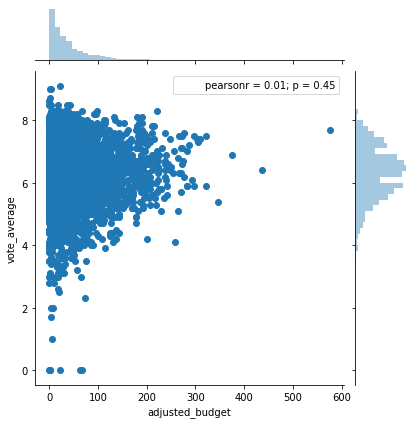

In [9]:
import scipy.stats as stats

ax = sns.jointplot(x='adjusted_budget',y='vote_average',data=mv_rate, kind='scatter').annotate(stats.pearsonr)

It seems that higher budget didn't followed by higher rating, also we got only 0.01 for pearsonr, it indicates no tangible relation between budget and rating. How about runtime?

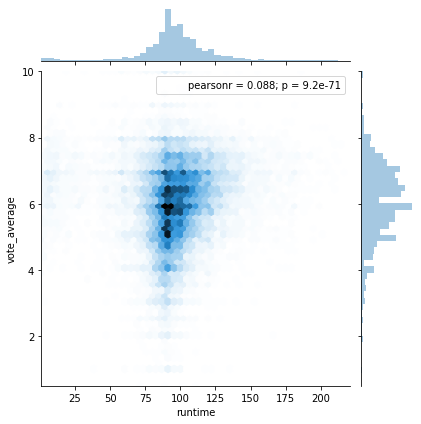

In [10]:
#I only choose for movie
df_movies['runtime'] = df_movies.runtime.fillna(0).astype('int')
run = df_movies[(df_movies.runtime<222) & (df_movies.runtime>0) & (df_movies.vote_average>0)]

ax = sns.jointplot(x='runtime',y='vote_average',data=run, kind='hex').annotate(stats.pearsonr)

It seems that runtime also do not have a meaningful relationship with rating. Lets see how about budget vs rating.

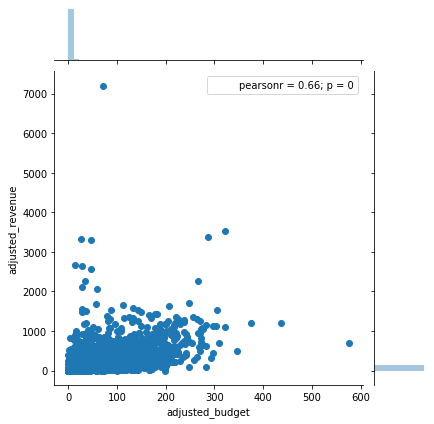

In [11]:
ax = sns.jointplot(x='adjusted_budget',y='adjusted_revenue',data=df_movies, kind='scatter').annotate(stats.pearsonr)

Pearsonr value of **0.63** indicates a strong positive correlation between budget and revenue. It's likely that higher the budget, the higher the revenue

## Analysis within Genre
We're going to see analysis for each genre, for instance, what is the most profitable genre? or what about their rating?

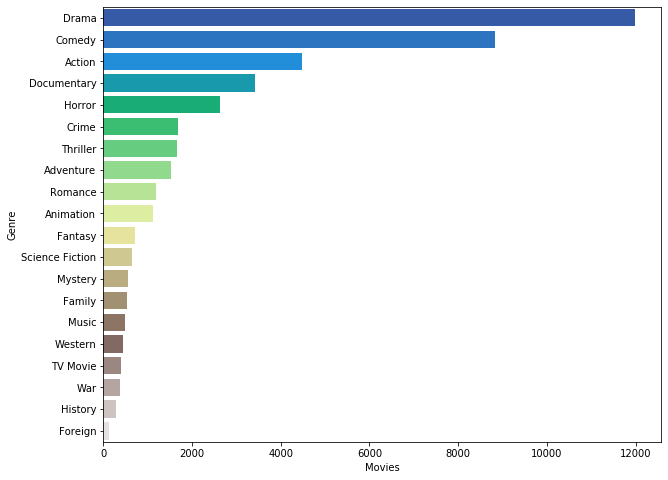

In [12]:
pop_gen = df_movies.groupby('genre1')['genre2'].size().reset_index().sort_values('genre2', ascending=False)
pop_gen.columns = ['Genre','Movies']
pop_gen.head(10)

fig,ax = plt.subplots()
fig.set_size_inches(10, 8)

ax = sns.barplot(y='Genre',x='Movies',data=pop_gen, palette='terrain')

So we got Drama for the most produced movie by **11982** movies, followed by Comedy and Action. Next, we see which genre has the highest budget and revenue.

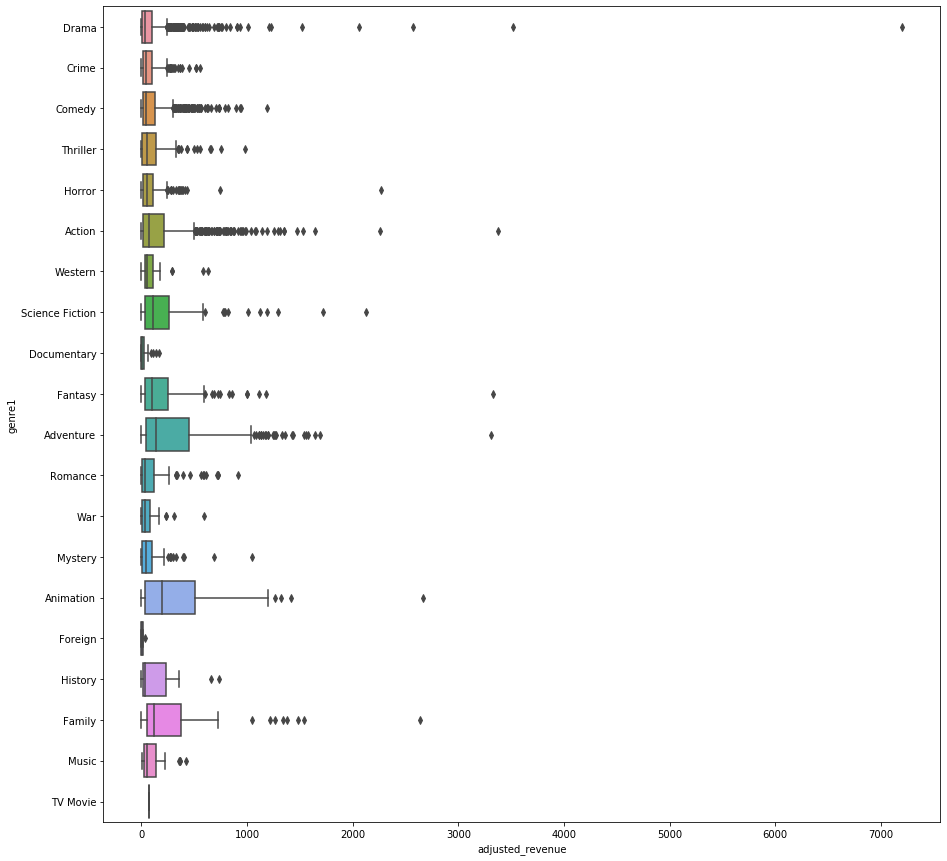

In [13]:
fig,ax = plt.subplots()
fig.set_size_inches(15, 15)

sort_rev = df_movies.sort_values('adjusted_revenue')
sort_rev = sort_rev[sort_rev.adjusted_revenue>0 ]

ax = sns.boxplot(y='genre1',x='adjusted_revenue',data=sort_rev)

In [14]:
sort_rev[(sort_rev.genre1=='Drama')&(sort_rev.adjusted_revenue>6000)]

,id,franchise,collection_poster,title,release_date,actor_lead,Director,genre1,genre2,original_language,...,runtime,vote_average,vote_count,budget,adjusted_budget,revenue,adjusted_revenue,overview,tagline,poster_path
231,770,,,Gone with the Wind,1939-12-15,Vivien Leigh,Victor Fleming,Drama,Romance,en,...,238,7.7,995.0,4.0,72.0,400.176459,7203.176262,An American classic in which a manipulative wo...,The greatest romance of all time!,/4o1yeosjSFMaI9pe1rOkYcZ6hHO.jpg


Since there are so much outlier for the revenue, we could use median

In [15]:
genre_df = sort_rev[['title','genre1','adjusted_budget','adjusted_revenue','vote_average','vote_count']].sort_values('genre1')

genre_df = pd.DataFrame(genre_df.groupby('genre1')[['adjusted_budget','adjusted_revenue','vote_average','vote_count']].median()).reset_index().sort_values('adjusted_revenue')

    
genre_df.head()

,genre1,adjusted_budget,adjusted_revenue,vote_average,vote_count
9,Foreign,0.577125,2.070949,5.80,5.5
5,Documentary,2.082500,3.981046,6.95,43.0
6,Drama,18.480000,30.000000,6.70,183.0
14,Romance,21.600000,30.302039,6.50,184.0
18,War,34.648000,30.619413,6.70,101.5


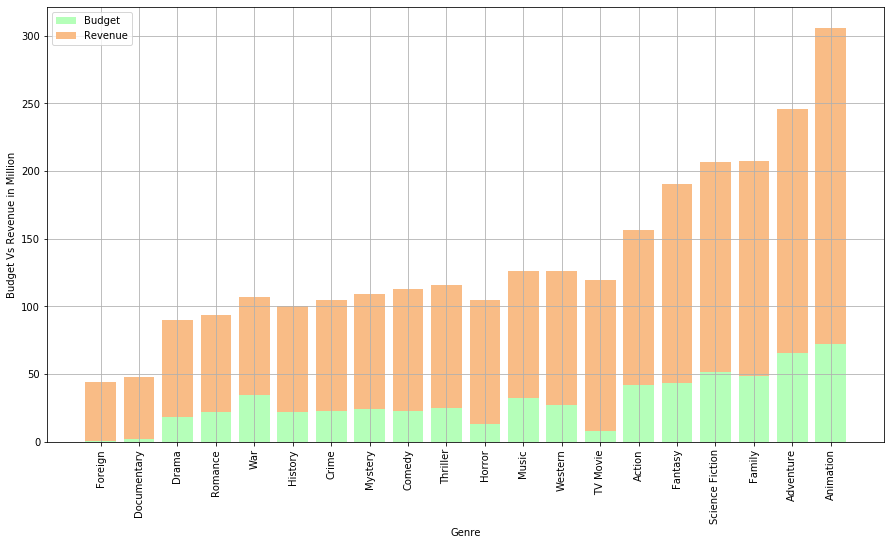

In [16]:
fig,ax = plt.subplots()
fig.set_size_inches(15, 8)

ax = plt.bar(genre_df.genre1,genre_df.adjusted_budget,color='#b5ffb9',label='Budget')
ax = plt.bar(genre_df.genre1,genre_df.adjusted_revenue,bottom=genre_df.adjusted_budget,color='#f9bc86',label='Revenue')
ax = plt.xlabel('Genre')
ax = plt.ylabel('Budget Vs Revenue in Million')
plt.grid(True)
plt.legend()
plt.xticks(rotation=90)
plt.show()

From the graph we could see that Animation movies have the highest revenue and also the most expensive to produce.

## Time Analysis
Lets find out how is the growth of movie industry, and find out what is the most popular month to release movies.

In [17]:
df_movies['year'] = df_movies.release_date.dt.year.fillna(0).astype('int')

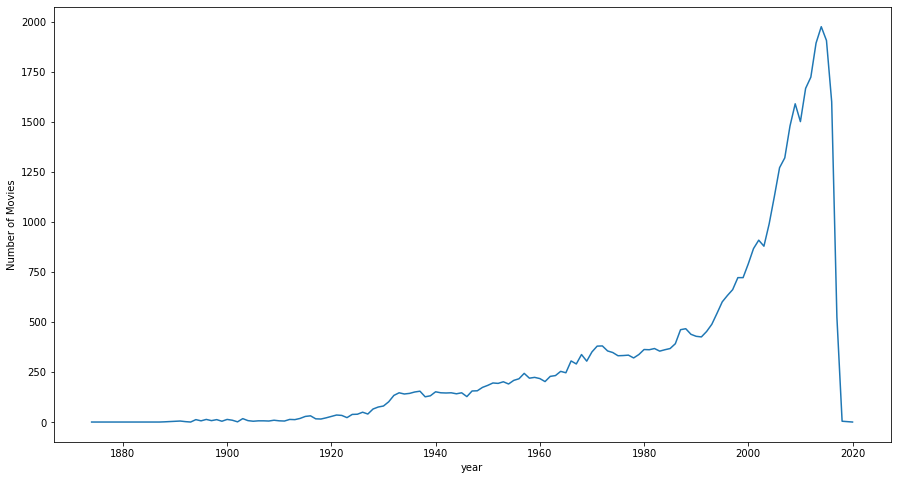

In [18]:
fig,ax = plt.subplots()
fig.set_size_inches(15, 8)

year_of_movies = df_movies.groupby('year').size().reset_index().iloc[1:] #We remove first row because it's for nan value
ax = sns.lineplot(x='year',y=0,data=year_of_movies)
ax = plt.ylabel('Number of Movies')

Wow, look at that growth. This industry growth so fast at the late 90s

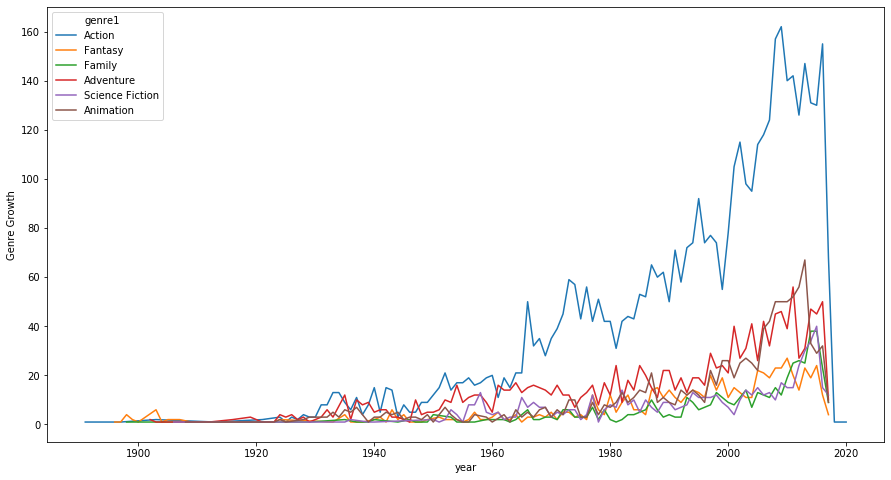

In [19]:
pop_genre = ['Animation','Adventure','Family','Science Fiction','Fantasy','Action']
years_genre = df_movies.groupby(['year','genre1']).size().reset_index()
years_genre = years_genre[(years_genre.year>0) & (years_genre.genre1.isin(pop_genre))]

fig,ax = plt.subplots()
fig.set_size_inches(15, 8)

ax = sns.lineplot(x='year',y=0,data=years_genre,hue='genre1')
ax = plt.ylabel('Genre Growth')

We could see that Action genre has become a trend from late 60s.

### Popular month for movies 

In [20]:
df_movies['month'] = df_movies.release_date.dt.month.fillna(0).astype('int')

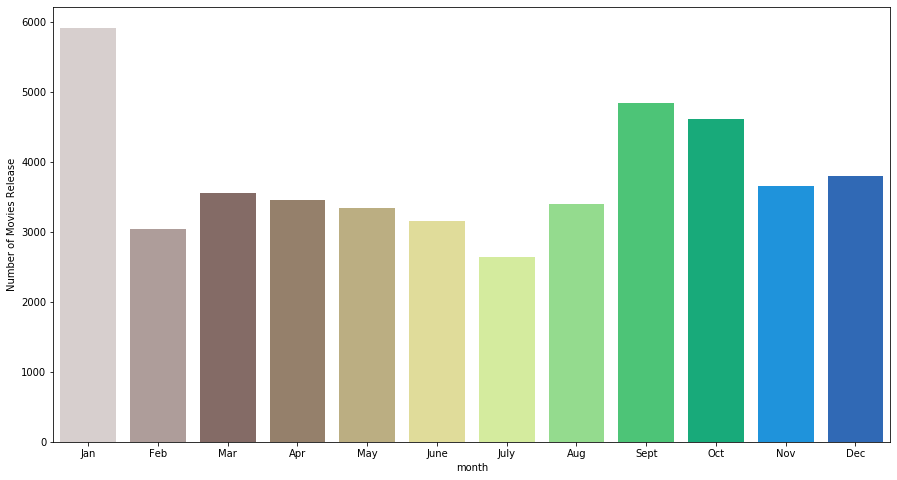

In [21]:
month = df_movies.groupby('month')['title'].size().reset_index().iloc[1:]

fig,ax = plt.subplots()
fig.set_size_inches(15, 8)

ax = sns.barplot(x='month',y='title',data=month,palette='terrain_r')
ax = plt.xticks([i for i in range (0,12)],['Jan','Feb','Mar','Apr','May','June','July','Aug','Sept','Oct','Nov','Dec'])
ax = plt.ylabel('Number of Movies Release')

**January** is the most popular month to release movies. Let see what month did blockbuster movies usually released? For this, we will only take movie with gross excess 150 million dollar.

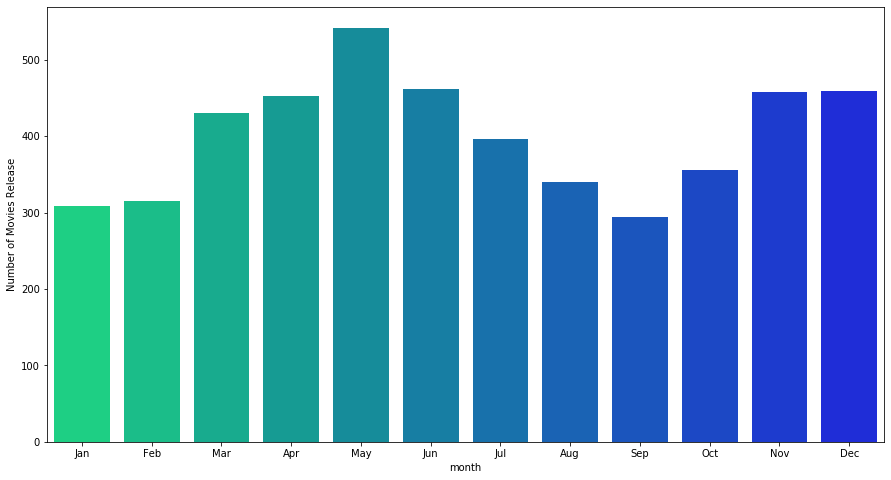

In [22]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_avg = df_movies[df_movies.adjusted_revenue>150]
month_avg = month_avg.groupby('month')['adjusted_revenue'].mean().reset_index()

fig,ax = plt.subplots()
fig.set_size_inches(15, 8)

ax = sns.barplot(x='month',y='adjusted_revenue',data=month_avg,palette='winter_r')
ax = plt.xticks([i for i in range (0,12)], month_order)
ax = plt.ylabel('Number of Movies Release')

From the graph we could see that most of blockbuster movies released during holiday period, like summer, and christmas-new years eve. Next, lets see heatmap to indicate hot and cold month from 2000.

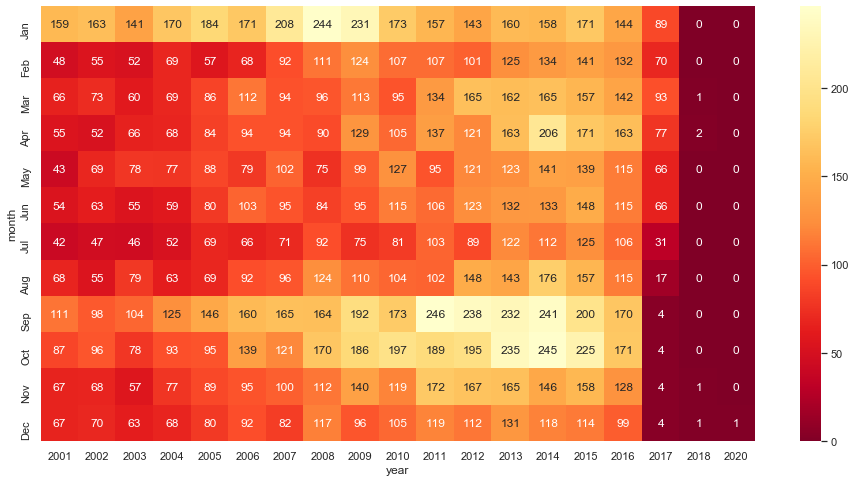

In [23]:
cent_21 = df_movies[df_movies.year>2000]
heatmap_21 = pd.pivot_table(data=cent_21,index='month',columns='year',aggfunc='count',values='title').fillna(0)

sns.set(font_scale=1)
fig,ax = plt.subplots()
fig.set_size_inches(16, 8)

sns.heatmap(heatmap_21, annot=True, ax=ax, fmt='n', yticklabels=month_order, cmap='YlOrRd_r')
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5) #there's a bug with matplotlib and seaborn,
plt.show()                           #we use this to correct the plot.

## Word Cloud
Let's see what is the most common word used in title and overview.

(-0.5, 3999.5, 1999.5, -0.5)

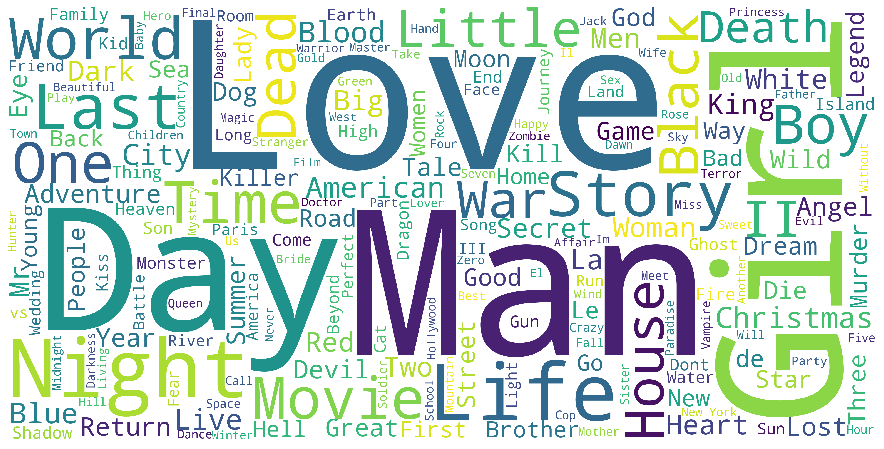

In [24]:
from wordcloud import WordCloud, STOPWORDS

df_movies['title'] = df_movies.title.astype('str')
df_movies['overview'] = df_movies.overview.astype('str')

title_cloud = ' '.join(df_movies['title'])
overview_cloud = ' '.join(df_movies['overview'])

title_word_cloud = WordCloud(stopwords=STOPWORDS, background_color='white'
                             , height=2000, width=4000).generate(title_cloud)
plt.figure(figsize=(16,8))
plt.imshow(title_word_cloud)
plt.axis('off')


Love, Man, Girl are the most commonly words to use in the title.

(-0.5, 3999.5, 1999.5, -0.5)

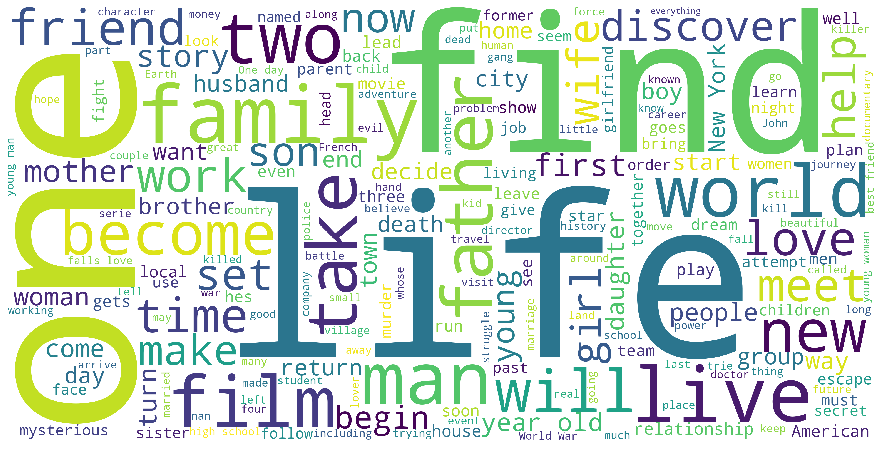

In [25]:
overview_word_cloud = WordCloud(stopwords=STOPWORDS, background_color='white'
                             , height=2000, width=4000).generate(overview_cloud)
plt.figure(figsize=(16,8))
plt.imshow(overview_word_cloud)
plt.axis('off')

Life, find and one are the most common word to use in overview. With title, they establish the mood or theme of the movie

## Production Companies
Lets find out what production companies have produced most films, and most money

In [26]:
size= pd.DataFrame(df_movies.groupby('company1').size().sort_values(ascending=False))
size.columns = ['Movies Produced']
rev_total = pd.DataFrame(df_movies.groupby('company1')['adjusted_revenue'].sum().sort_values(ascending=False))
rev_total.columns = ['Total Earning']
cum_sum = pd.DataFrame(df_movies.groupby('company1')['adjusted_revenue'].mean().sort_values(ascending=False))
cum_sum.columns = ['Average Earning']

comp_summary = pd.concat((size,rev_total,cum_sum), axis=1).sort_values(['Movies Produced','Total Earning'], ascending=False)
comp_summary.head(10)

c:\program files\python\python37\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  


,Movies Produced,Total Earning,Average Earning
Paramount Pictures,994,73312.890722,73.755423
Metro-Goldwyn-Mayer (MGM),854,7820.436611,9.157420
Twentieth Century Fox Film Corporation,777,50666.981690,65.208471
Warner Bros.,757,22438.767126,29.641700
Universal Pictures,753,66620.017995,88.472799
Columbia Pictures,426,40366.711334,94.757538
Columbia Pictures Corporation,401,14489.172869,36.132601
RKO Radio Pictures,290,6172.848928,21.285686
United Artists,272,20476.180665,75.280076
Walt Disney Pictures,261,50950.160029,195.211341


**Paramount Pictures** is produced most movies with **994** total movies and also is the highest earning money with **$72.7 billion** dollars. But they are not the highest average earning, lets find out **who is the most successful in terms of average earning.**

In [27]:
comp_summary[comp_summary['Movies Produced']>20].sort_values('Average Earning', ascending=False).head()

,Movies Produced,Total Earning,Average Earning
Lucasfilm,29,18737.277692,646.113024
Ingenious Film Partners,28,8874.291161,316.938970
Marvel Studios,24,7043.782761,293.490948
DreamWorks Animation,29,7957.216960,274.386792
Amblin Entertainment,24,5187.656358,216.152348


From the data, **Lucasfilm** is the highest average earning with average earning **$646 million** per-movie. They produced well-known movies like Star Wars and Indiana Jones, and in 2nd we got Marvel with their The Avengers series

## Actors and Director
Let's see several aspects for actor and director. First, lets see who has played in most movies.

In [28]:
actor = df_movies.groupby('actor_lead')['title'].size().reset_index().sort_values('title',ascending=False)
actor.head(10)

,actor_lead,title
8395,John Wayne,94
7104,Jackie Chan,73
12828,Nicolas Cage,60
14544,Robert De Niro,55
6240,Gérard Depardieu,52
2372,Burt Lancaster,50
11858,Michael Caine,50
2319,Bruce Willis,47
13492,Paul Newman,47
7701,Jeff Bridges,46


We got **John Wayne** in the first place with 94 movies.He started his carrier in 1920 and started to play in hit movies from 1940-1970. Next, lets see which actor is the most successful in terms of revenue earning.

In [29]:
act_rev = df_movies.groupby('actor_lead')['adjusted_revenue'].sum().reset_index().sort_values('adjusted_revenue',ascending=False)
act_rev.head(10)

,actor_lead,adjusted_revenue
16891,Tom Cruise,12255.970340
16910,Tom Hanks,12048.924385
3641,Daniel Radcliffe,10087.618252
8404,Johnny Depp,9344.750242
6379,Harrison Ford,7966.094333
16374,Sylvester Stallone,7893.341283
17783,Will Smith,7826.925531
2319,Bruce Willis,7720.239250
14549,Robert Downey Jr.,7384.373625
17582,Vivien Leigh,7283.176262


We got **Tom Cruise** in first place with total revenue **$12 billion**, and followed by Tom Hanks and Daniel Radcliffe. Now, lets see which director has most movies and yield most money.

In [30]:
Dir = df_movies.groupby('Director')['title'].size().reset_index().sort_values('title',ascending=False)
Dir.head(10)

,Director,title
8057,John Ford,66
11294,Michael Curtiz,65
17010,Werner Herzog,54
621,Alfred Hitchcock,53
5538,Georges Méliès,51
17188,Woody Allen,49
7382,Jean-Luc Godard,47
15189,Sidney Lumet,46
2561,Charlie Chaplin,44
13538,Raoul Walsh,43


**John Ford** had directed most movies with **66** movies. He'd won 4 Academy Awards as the Best Director. Now, lets see who is the most successful director in terms of total revenue.

In [31]:
dir_rev = df_movies.groupby('Director')['adjusted_revenue'].sum().reset_index().sort_values('adjusted_revenue',ascending=False)
dir_rev.head(10)

,Director,adjusted_revenue
15626,Steven Spielberg,18368.207535
6932,James Cameron,9382.830335
13025,Peter Jackson,8336.808806
11257,Michael Bay,8123.005822
16755,Victor Fleming,7886.920268
5497,George Lucas,7632.547727
14184,Robert Zemeckis,7116.909580
3665,David Hand,5997.992748
2663,Chris Columbus,5823.072375
16175,Tim Burton,5798.822453


**Steven Spielberg** is the most successful director with total **$18 billion** of revenue from all of his movies. He directed many famous movies like Indiana Jones, Jurassic Park series, and many more.

## Franchise and Movies
We know that some movies have sequel or prequel, now we're going to see which movies franchise is produced most movies? which one is the most succeed? which movies have highest gross and which one is a movie industry disaster?

In [32]:
from IPython.core.display import Image, HTML

df_poster = df_movies[['collection_poster','franchise','adjusted_revenue']]
df_poster = df_poster[df_poster.franchise != '']

size_col = df_poster.groupby('franchise').size().reset_index().rename(columns={0:'Number of Movies'}).sort_values('Number of Movies',ascending=False)
poster = df_poster.groupby('franchise').first().reset_index()
poster['collection_poster'] = 'https://image.tmdb.org/t/p/w500'+poster['collection_poster']

size_col = size_col.merge(poster, on='franchise').head()
size_col = size_col[['collection_poster','franchise','Number of Movies']]

def path_to_image_html(path):
    return '<img src="'+ path + '" width="80" >'

pd.set_option('display.max_colwidth', 50)

HTML(size_col.to_html(escape=False, formatters=dict(collection_poster=path_to_image_html)))



,collection_poster,franchise,Number of Movies
0,,The Bowery Boys,29
1,,Totò Collection,27
2,,James Bond Collection,26
3,,Pokémon Collection,26
4,,Zatôichi: The Blind Swordsman,26


So we Got **The Bowery Boys** for the most movies in a franchise by 29 movies, followed by Toto Collection and James Bond. Next, lets see which franchise got most revenue.

In [33]:
rev_col = df_poster.groupby('franchise')['adjusted_revenue'].sum().reset_index().rename(columns={'adjusted_revenue':'Total Revenue'}).sort_values('Total Revenue',ascending=False)
top = rev_col.head(10)
top = top.merge(poster, on='franchise')[['collection_poster','franchise','Total Revenue']]

pd.set_option('display.max_colwidth', 50)

HTML(top.to_html(escape=False, formatters=dict(collection_poster=path_to_image_html)))


,collection_poster,franchise,Total Revenue
0,,James Bond Collection,16960.949704
1,,Star Wars Collection,13421.092902
2,,Harry Potter Collection,9934.514258
3,,The Fast and the Furious Collection,5828.552550
4,,Pirates of the Caribbean Collection,5533.274764
5,,Transformers Collection,5022.236144
6,,The Lord of the Rings Collection,4183.685127
7,,Despicable Me Collection,4066.431270
8,,The Twilight Collection,3917.003516
9,,Ice Age Collection,3903.337488


So we have **James Bond Collection** with total revenue of **$16.9 billion**, followed by Star Wars and Harry Potter

### Highest Grossing Movie of All Time

In [34]:
gross_mv = df_movies[['poster_path','title','adjusted_revenue','year']]
gross_mv['poster_path'] = 'https://image.tmdb.org/t/p/w500'+gross_mv['poster_path']
gross_mv.sort_values('adjusted_revenue',ascending=False,inplace=True)
HTML(gross_mv.head(10).to_html(escape=False, formatters=dict(poster_path=path_to_image_html)))

c:\program files\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\program files\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,poster_path,title,adjusted_revenue,year
231,,Gone with the Wind,7203.176262,1939
1,,Titanic,3518.449406,1997
0,,Avatar,3373.437755,2009
712,,Snow White and the Seven Dwarfs,3328.658748,1937
68,,Star Wars,3310.949490,1977
807,,Bambi,2669.334000,1942
461,,Cinderella,2635.914150,1950
200,,The Exorcist,2572.814825,1973
179,,Jaws,2263.845740,1975
2,,Star Wars: The Force Awakens,2254.363750,2015


We got **Gone with the Wind** as the highest grossing movie of all time with adjusted revenue about **$7 billion**. Next lets see movies with the lowest revenue of this industry.

In [35]:
lowest = gross_mv[gross_mv.adjusted_revenue!=0]
lowest.sort_values('adjusted_revenue',inplace=True)
HTML(lowest.head(10).to_html(escape=False, formatters=dict(poster_path=path_to_image_html)))

c:\program files\python\python37\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,poster_path,title,adjusted_revenue,year
7291,,The House of Usher,0.002096,2007
7295,,Poor White Trash,0.002106,2000
7288,,Best Man Down,0.002190,2012
7289,,"Love, Wedding, Marriage",0.002215,2011
7293,,Running Time,0.002570,1997
7283,,The Samaritan,0.002849,2012
7278,,About Cherry,0.003393,2012
7277,,ATM,0.003401,2012
7274,,Aftermath,0.003658,2017
7275,,Sleepless Night,0.003862,2011


We got **The House of Usher** for gross only **$2096**.

For next notebook, i build a classifier that could predict probability id movie will be a hit or flop. Check it out!